In [1]:
import numpy as np
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
from tensorflow import keras
import os
from tensorflow.keras import layers
import tensorflow_hub as hub
import itertools

2024-03-07 10:35:54.903052: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-07 10:35:54.931595: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 10:35:55.081455: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 10:35:55.081491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 10:35:55.110459: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
dataset = tf.keras.utils.image_dataset_from_directory(  
    "Alz_Datasets/Alz2/Axial/",
    shuffle = True,
    image_size = (256,170)
)

Found 5154 files belonging to 3 classes.


In [3]:

# training_images = []
# training_labels = []

# for images , labels in dataset:
#     training_images.append(images)
#     training_labels.append(labels)

batch_size = 32
image_height = 256
image_width = 170


#
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "Alz_Datasets/Alz2/Axial/",
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (image_height,image_width),
    batch_size = (batch_size)
)

Found 5154 files belonging to 3 classes.
Using 4124 files for training.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "Alz_Datasets/Alz2/Axial/",
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (image_height,image_width),
    batch_size = (batch_size)
)

Found 5154 files belonging to 3 classes.
Using 1030 files for validation.


In [5]:
class_names = train_dataset.class_names
print(class_names)

['AD', 'CI', 'CN']


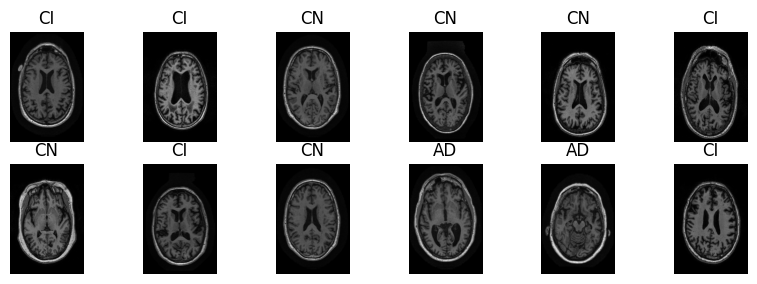

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 256, 170, 3)
(32,)


In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [25]:
model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs= 10
)


Epoch 1/10


129/129 [==============================] - 26s 195ms/step - loss: 0.9333 - accuracy: 0.5563 - val_loss: 0.7558 - val_accuracy: 0.6631
Epoch 2/10
129/129 [==============================] - 25s 191ms/step - loss: 0.6105 - accuracy: 0.7573 - val_loss: 0.4306 - val_accuracy: 0.8466
Epoch 3/10
129/129 [==============================] - 24s 183ms/step - loss: 0.3309 - accuracy: 0.8872 - val_loss: 0.2587 - val_accuracy: 0.9117
Epoch 4/10
129/129 [==============================] - 24s 183ms/step - loss: 0.1638 - accuracy: 0.9566 - val_loss: 0.1485 - val_accuracy: 0.9466
Epoch 5/10
129/129 [==============================] - 24s 183ms/step - loss: 0.0865 - accuracy: 0.9801 - val_loss: 0.0764 - val_accuracy: 0.9835
Epoch 6/10
129/129 [==============================] - 24s 183ms/step - loss: 0.0493 - accuracy: 0.9908 - val_loss: 0.0680 - val_accuracy: 0.9845
Epoch 7/10
129/129 [==============================] - 24s 186ms/step - loss: 0.0326 - accuracy: 0.9952 - val_loss: 0.0411 - val_accuracy: 0.9

In [11]:
model.save("model.keras")


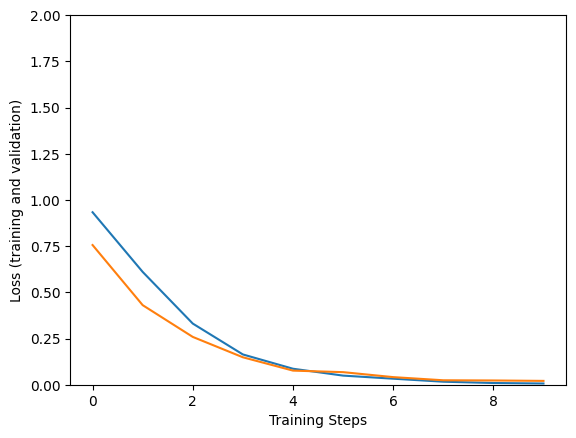

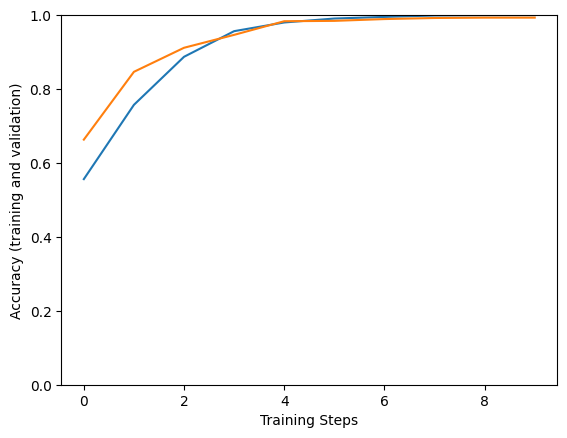

In [26]:
train_size = len(train_dataset)
valid_size = len(validation_dataset)
BATCH_SIZE = 32
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE


hist = model.history.history


plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])